In [ ]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from datasets import load_dataset
import pandas as pd
import numpy as np

In [ ]:
my_model = "YeRyeongLee/roberta-base-finetuned-filtered-0609"

In [ ]:
path = "/content/drive/MyDrive/소캡디/"

data_category = 'filtered'
data_files = {
    'train': path + 'train_'+data_category+'_5300.csv',
    'valid': path + 'valid_'+data_category+'_5300.csv',
    'test': path + 'test_'+data_category+'_5300.csv',
}

In [ ]:
mental_health = load_dataset("csv", data_files=data_files)
labels = ['adhd', 'anxiety', 'bipolar', 'depression', 'non_mh', 'schizo']

Using custom data configuration default-b9d3fdd93fda408c
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-b9d3fdd93fda408c/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(my_model)

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
mental_encoded = mental_health.map(tokenize, batched=True, batch_size=8)

y_train = np.array(mental_encoded["train"]["label"])
y_valid = np.array(mental_encoded["valid"]["label"])
y_test = np.array(mental_encoded["test"]["label"])

Parameter 'function'=<function tokenize at 0x7f116f377050> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/3180 [00:00<?, ?ba/s]

  0%|          | 0/398 [00:00<?, ?ba/s]

  0%|          | 0/398 [00:00<?, ?ba/s]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels, filename):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Confusion matrix")
    # plt.show()
    plt.savefig(path + filename)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(my_model)
num_labels = 6

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  recall = recall_score(labels, preds, average='weighted')
  precision = precision_score(labels, preds, average='weighted')
  return {"accuracy": acc, "f1": f1, "recall": recall, "precision": precision}

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(mental_encoded["train"])
model_name = "temp"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=4,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level='error')

from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=mental_encoded["train"],
                  eval_dataset=mental_encoded["valid"],
                  tokenizer=tokenizer)

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

{'test_loss': 0.11999337375164032, 'test_accuracy': 0.9783018867924528, 'test_f1': 0.978232933414211, 'test_recall': 0.9783018867924528, 'test_precision': 0.9783346479848279, 'test_runtime': 102.1698, 'test_samples_per_second': 31.125, 'test_steps_per_second': 3.895}
automodel for sequence classifier - test set
acc = 0.9783018867924528%


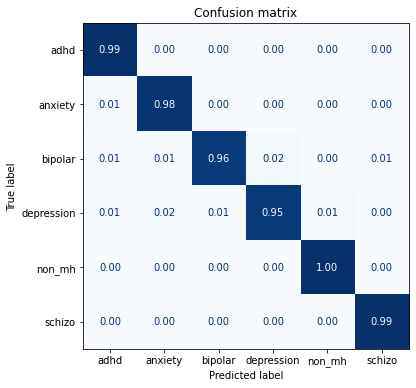

In [ ]:
pred_output = trainer.predict(mental_encoded["test"])
pred_output.metrics

y_pred = np.argmax(pred_output.predictions, axis=1)
acc = pred_output.metrics['test_accuracy']
print(pred_output.metrics)

print('automodel for sequence classifier - test set')
print(f'acc = {acc}%')
plot_confusion_matrix(y_pred, y_test, labels, "cm_roberta_cased_final.png")